## DSCI 552 : HomeWork 4: Part-B

### Name: Jayantraj CS (USC ID: 3993-1362-35)

In [1]:
# Import Statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
import seaborn as sns
from sklearn.impute import SimpleImputer
import time as t
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import math
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import os
java_home = os.environ.get('JAVA_HOME', None)
java_path=''
if not java_home:
    java_path = '/Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home'
    os.environ['JAVA_HOME'] = java_path
else:
    print(java_home)

import weka.core.jvm as jvm
import javabridge
jvm.start()
from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/opt/anaconda3/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/opt/anaconda3/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/opt/anaconda3/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/opt/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/opt/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


/Library/Java/JavaVirtualMachines/jdk-9.0.4.jdk/Contents/Home


## *Question 2.) Tree-Based Methods*

## *Question 2.a) Download the APS Failure data.*

In [34]:
# Skipping the first 20 rows of the CSV files, since we can't use them for analysis.

aps_train_data = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20, na_values = 'na')
aps_test_data = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20, na_values = 'na')
aps_data = pd.concat([aps_train_data, aps_test_data])
aps_data_x = aps_data.iloc[:,1:]
aps_data_y = aps_data.iloc[:,0]

aps_train_data_y = aps_train_data.iloc[:, 0]
aps_test_data_y = aps_test_data.iloc[:, 0]

## *Question 2.b) Data Preparation*

## *Question 2.b.i). Research what types of techniques are usually used for dealing with data with missing values.Pick at least one of them and apply it to this data in the next steps.*

### *1. The simplest strategy for handling missing data is to remove samples that contain a missing value. The major disadvantage of this strategy is that we will lose a lot of data. It works poorly if the percentage of missing values is high(say 30%), compared to the whole dataset.*

### *2. The next strategy for handling missing data is to fill in the missing values, which is called data imputation. We can either replace a missing value with a constant or use statistics such as mean, median, mode of the missing value column to replace the missing values.*

### *2.1. There are two different types of imputations: univariate imputation and multivariate imputation. univariate imputation imputes values in the i-th feature dimension using only non-missing values in that feature dimension. By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values.*

### *3 .We can also replace the missing values with another predictive model. We shall treat the missing value as the output of the predictive model and predict it based on other data points that do not have any missing values.*


For this dataset, I will be using the mean imputer to fill in the missing values.

Reason for using mean imputer :

1. we are given that all columns are numeric, so it is not a bad idea to use the mean imputer.

2. I tried fitting it using other methods, such as using KNN, it took a lot of time to run and execute. For this reason, I am going in with a simple mean imputer.

### *As mentioned in the instructions: we will use the complete dataset to impute and then split it into TRAIN and TEST data.*

In [35]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
aps_new_data_x = pd.DataFrame(imputer.fit_transform(aps_data_x), columns=aps_data.columns[1:])

aps_train_data_x = aps_new_data_x[:60000]
aps_test_data_x = aps_new_data_x[60000:]

In [36]:
aps_new_data_x.head(4)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.000000,353400.000000,299160.000000,305200.000000,283680.000000,548709.014737,579698.517171,601299.256265,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.000000,96.000000,0.000000,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.000000,240.0,6700214.0,39.786342,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.000000,734.000000,4.122704e+06,51288.000000,0.000000,532572.000000,0.000000,18.000000,5.330690e+06,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.000000,359780.000000,366560.000000,462365.468981,511080.087907,548709.014737,579698.517171,601299.256265,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,150231.156793,91.980545,0.000455,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,150517.375485,0.0,3646660.0,39.786342,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,749.985224,1217.781236,1.930347e+06,353598.927318,255.084516,18878.968499,7.476827,13.268495,2.202093e+06,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698

In [37]:
aps_train_data_x.head(4)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.000000,353400.000000,299160.000000,305200.000000,283680.000000,548709.014737,579698.517171,601299.256265,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.000000,96.000000,0.000000,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.000000,240.0,6700214.0,39.786342,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.000000,734.000000,4.122704e+06,51288.000000,0.000000,532572.000000,0.000000,18.000000,5.330690e+06,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.000000,359780.000000,366560.000000,462365.468981,511080.087907,548709.014737,579698.517171,601299.256265,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,150231.156793,91.980545,0.000455,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,150517.375485,0.0,3646660.0,39.786342,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,749.985224,1217.781236,1.930347e+06,353598.927318,255.084516,18878.968499,7.476827,13.268495,2.202093e+06,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698

In [38]:
#Checking whether we have correctly split the data.

print('The shape of Features of Training Data',aps_train_data_x.shape)
print('The shape of Features of Test Data',aps_test_data_x.shape)

The shape of Features of Training Data (60000, 170)
The shape of Features of Test Data (16000, 170)


## *Question 2.b.ii) For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.*

In [39]:
def print_coefficient_variation(aps_new_data_x,num_of_features):
    CV=aps_new_data_x.apply(lambda pr:np.abs(np.std(pr)/np.mean(pr)),axis=0)
    features_with_high_cv = CV.sort_values(ascending=False)[:num_of_features]
    return features_with_high_cv

features_with_high_cv = print_coefficient_variation(aps_new_data_x,170)
print(features_with_high_cv)

cf_000    207.268910
co_000    206.874768
ad_000    206.720140
cs_009    192.521344
dj_000    122.127349
as_000    113.882006
dh_000    112.651709
df_000    111.368933
ag_000     91.460052
au_000     86.085071
ak_000     78.622470
az_009     77.999043
ay_009     77.460592
ch_000     57.497526
cs_008     57.201984
dz_000     49.248482
ay_001     49.248311
ef_000     47.919228
eg_000     45.650650
aj_000     43.144196
ag_001     42.084066
ay_000     40.902250
ay_002     38.342067
dl_000     37.456400
dk_000     36.517797
dg_000     34.676375
dm_000     34.551574
ay_004     33.039915
ea_000     32.777054
ag_009     32.166846
cn_009     30.961132
ay_003     28.329849
cy_000     28.005631
cn_000     27.974942
da_000     25.205729
at_000     23.186907
az_008     22.414731
ae_000     22.293524
dq_000     21.184459
ai_000     18.506186
af_000     18.208896
ag_002     17.625793
az_007     15.382056
cp_000     12.918907
cn_001     12.624456
cr_000     12.470539
cl_000     12.164231
az_002     12

## *Question 2.b.iii) Plot a correlation matrix for your features using pandas or any other tool.*

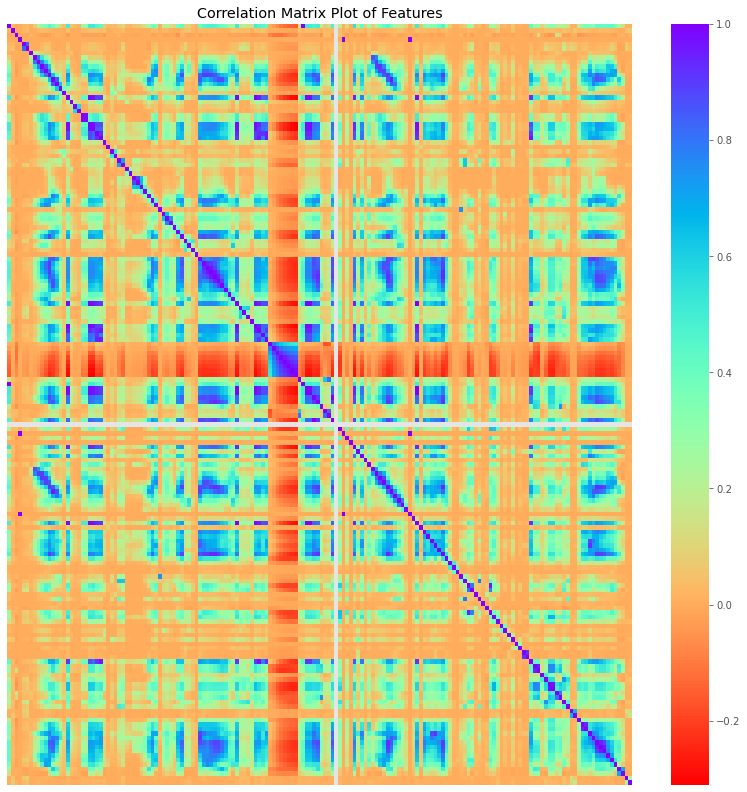

In [40]:
fit, axes = plt.subplots(figsize=(14, 14))
sns.heatmap(aps_new_data_x.corr(), cmap='rainbow_r',xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix Plot of Features")
plt.show()

## *Question 2.b.iv) Pick ⌊ 170⌋ features with highest CV , and make scatter plots and box plots for them.Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.*

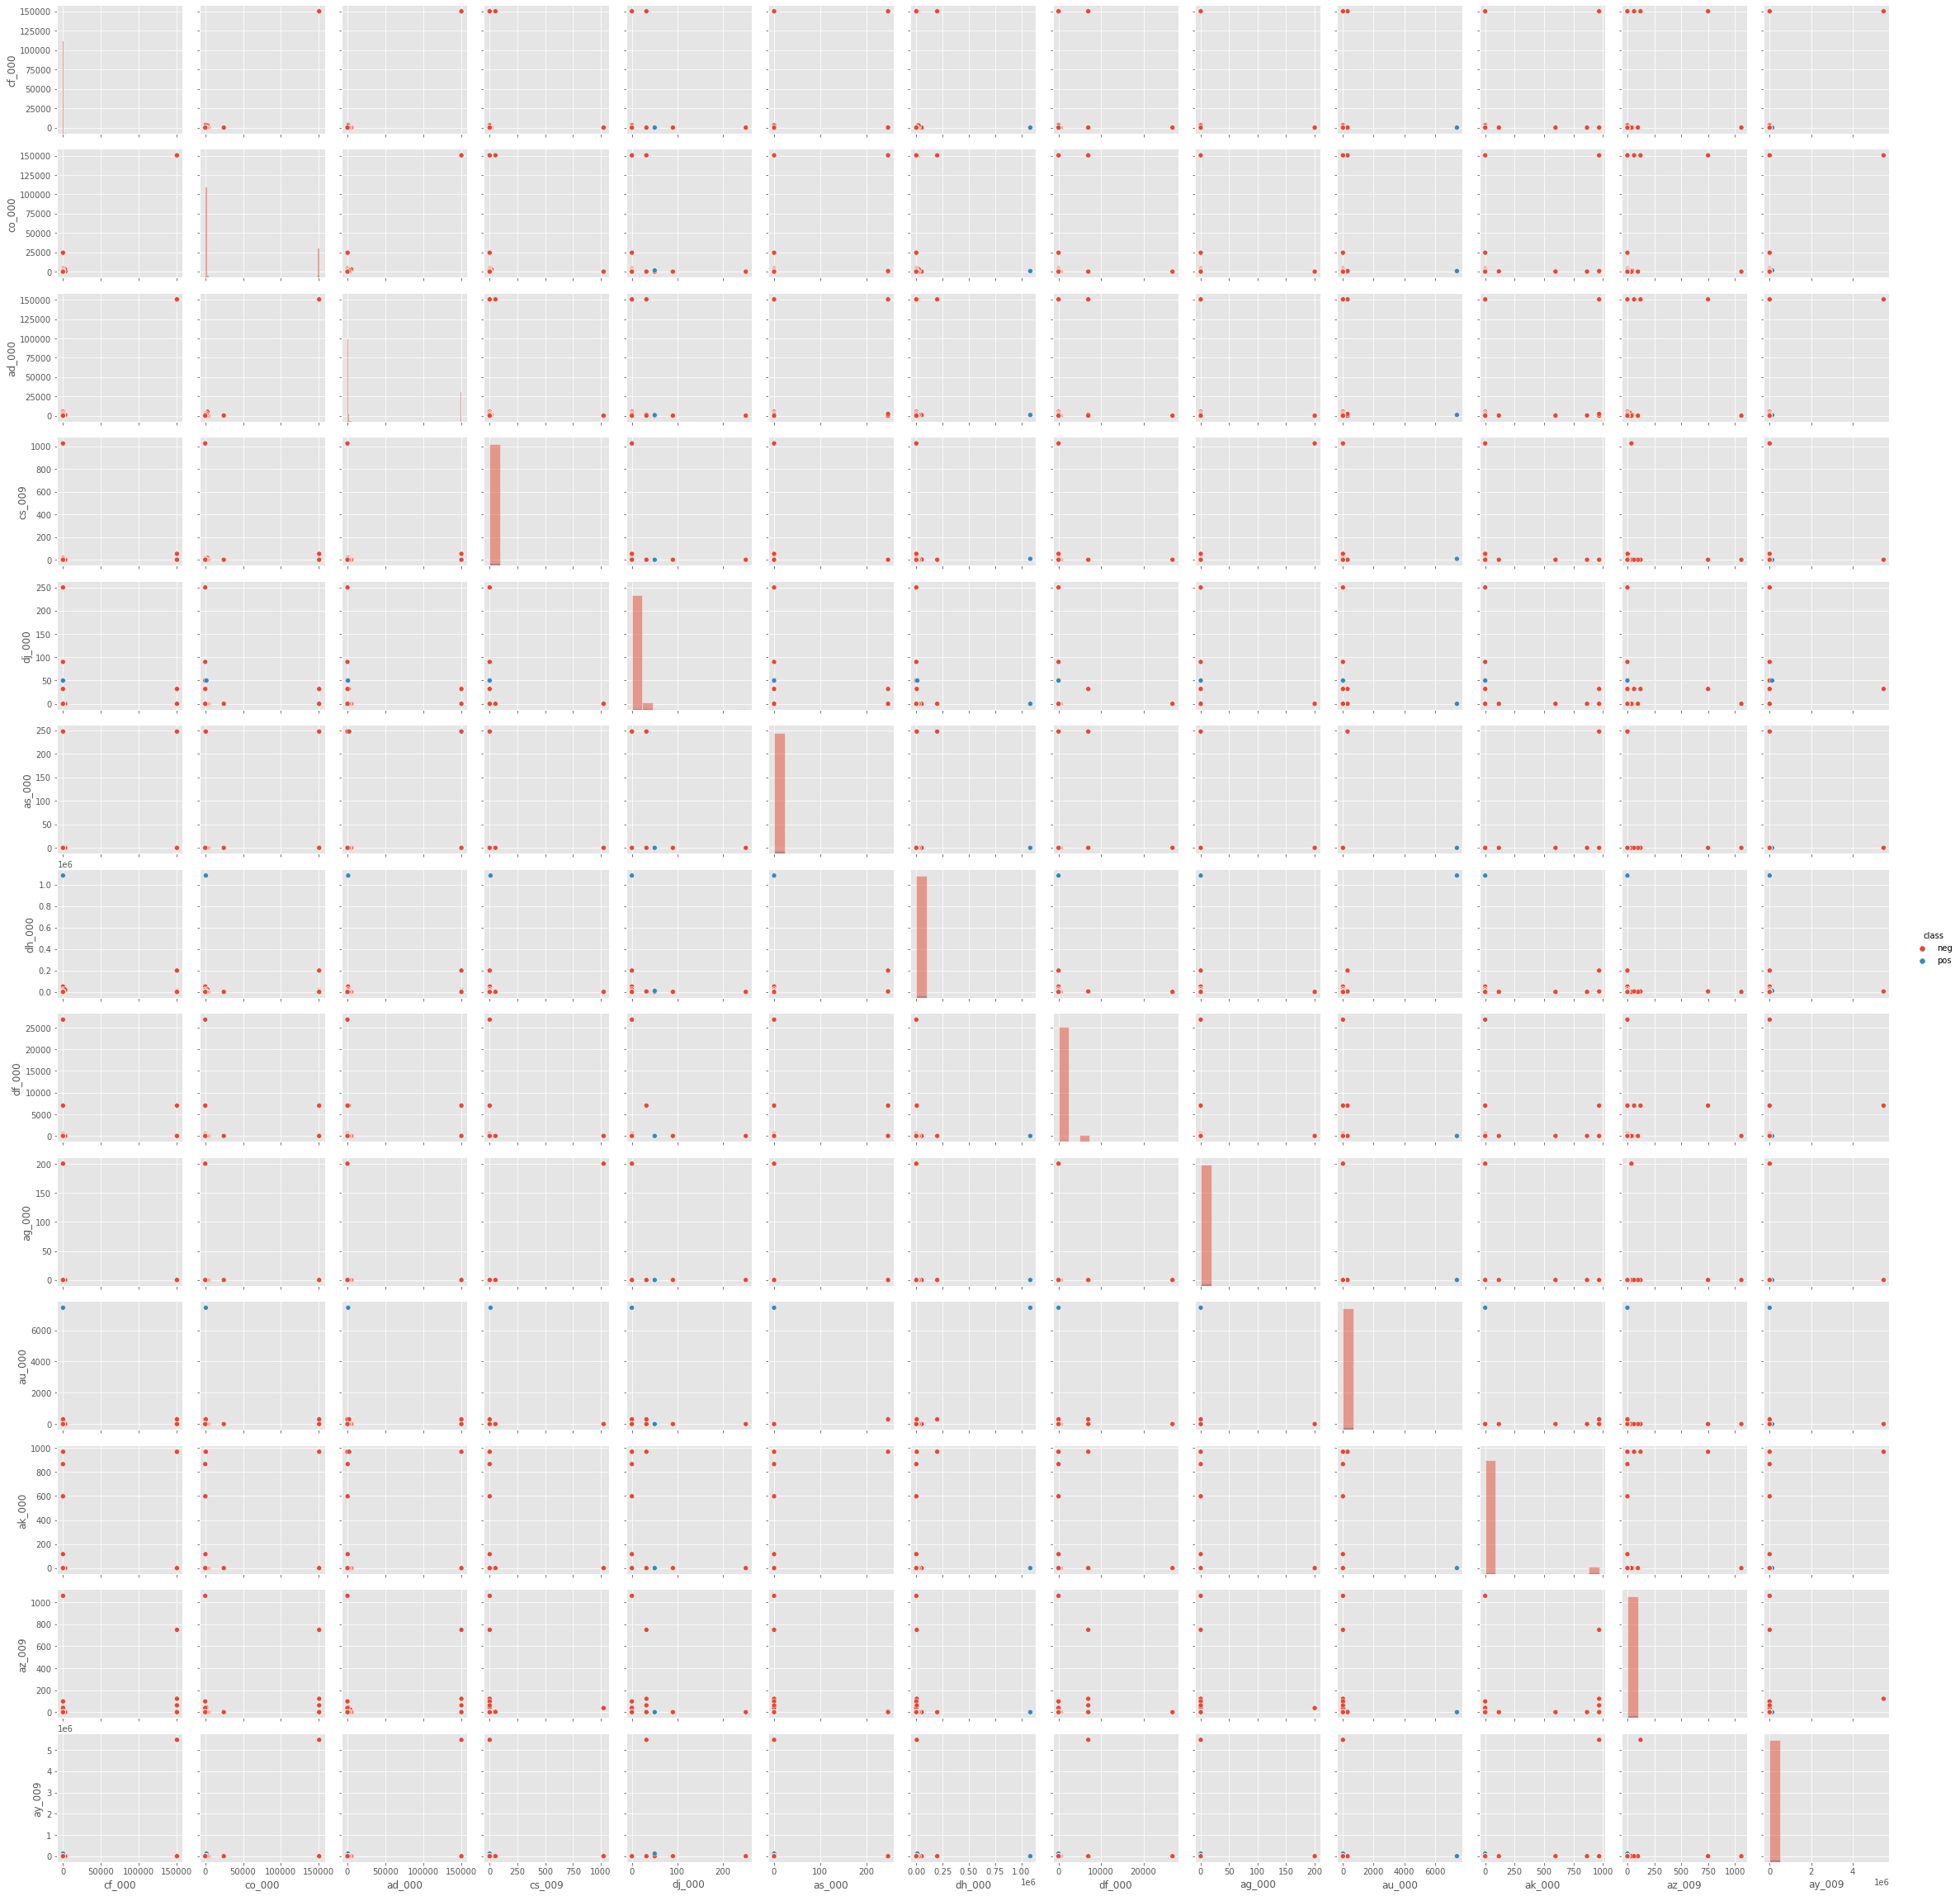

Time taken : 58.78235197067261


In [41]:
# I have only taken a 0.01 fraction of the sample because, samples of other size is taking forever time to run in my computer.

start = t.time()
features_with_high_cv = print_coefficient_variation(aps_new_data_x,int(np.floor(np.sqrt(170))))

total_data = aps_new_data_x[features_with_high_cv.index.to_list()].copy()
total_data['class'] = list(aps_data_y)


sns.pairplot(total_data.sample(frac=0.01), hue='class', diag_kind='hist')
plt.show()

end = t.time()

print("Time taken :",end-start)


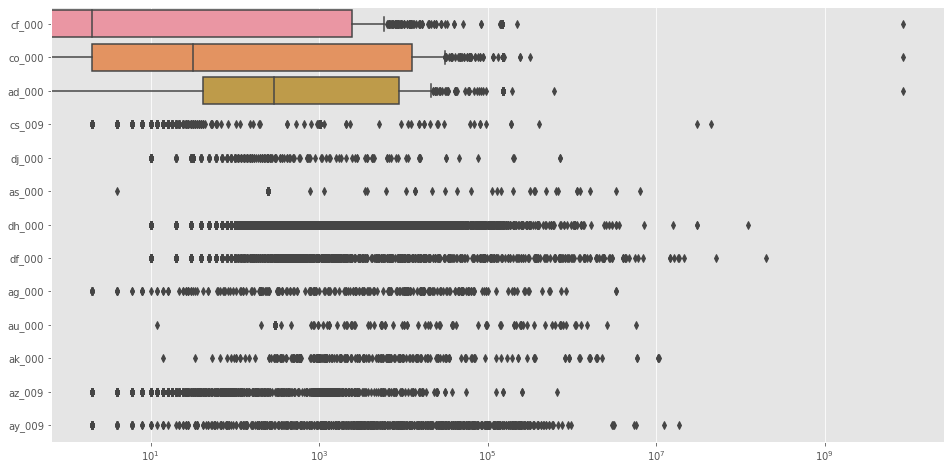

In [42]:
fig, axes = plt.subplots(figsize=(16, 8))
box = sns.boxplot(data=aps_new_data_x[features_with_high_cv.index.to_list()], orient='h', ax=axes)
box.set(xscale="log")
plt.show()

Just by seeing the scatter plots, we can't draw any conclusions about the significance of the features.

For each feature, we can see the distribution of the class label along the y-axis has no exact pattern and it is not enough to make any conclusions.

## *Question 2.b.v) Determine the number of positive and negative data. Is this data set imbalanced?*

In [43]:
aps_train_data_y.value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [44]:
aps_test_data_y.value_counts()

neg    15625
pos      375
Name: class, dtype: int64

Combinig them for both classes: 
</br> positive classes = 59000+15625 = 74625
</br> negative classes = 1000+375 = 1375

By looking at the count of the positive and negative classes, we can say that the dataset is clearly imbalanced.

## *Question 2.c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.*

In [45]:

def random_forest_classifier(balanced,aps_data_x,aps_data_y):
    if balanced:
        random_forest=RandomForestClassifier(max_depth=5, random_state=1234, verbose=1, oob_score=True,class_weight='balanced')
    else:
        random_forest = RandomForestClassifier(max_depth=5, random_state=1234,verbose=1,oob_score=True)
    
    random_forest.fit(aps_data_x, aps_data_y)
    predictions_of_data_y = random_forest.predict(aps_data_x)
    probablities_of_data_y = random_forest.predict_proba(aps_data_x)
    return random_forest,predictions_of_data_y,probablities_of_data_y


In [46]:
#Note we are using an imbalanced dataset.(Balanced variable is False)
start = t.time()
random_forest,predictions_of_train_data_y,probablities_of_train_data_y=random_forest_classifier(False,aps_train_data_x,aps_train_data_y)
end = t.time()

# approximately 22 seconds.
print('Total Time taken for execution :',end-start)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Total Time taken for execution : 24.344686269760132


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Calculations for Training Data


Confusion Matrix 
[[58980    20]
 [  433   567]]

The Random Forest Classification Accuracy 0.99245


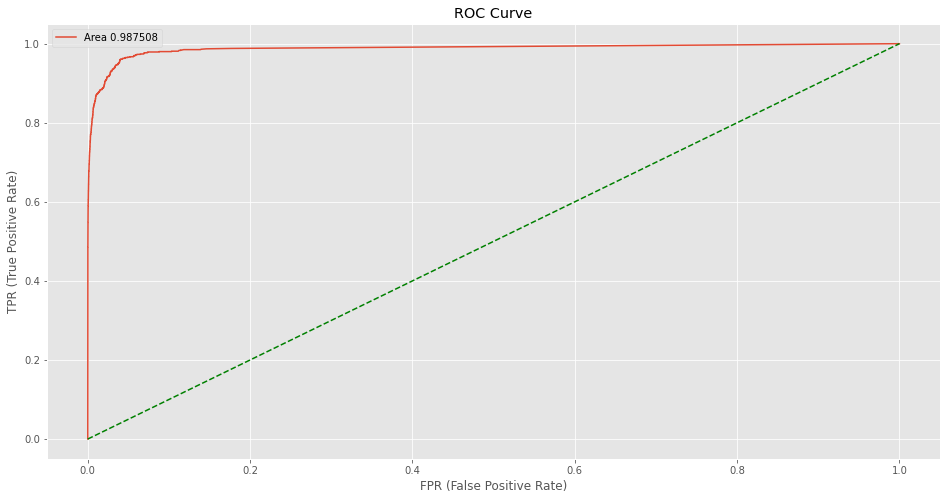

In [47]:

print('Calculations for Training Data\n\n')
confus_matrix = confusion_matrix(aps_train_data_y, predictions_of_train_data_y)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(aps_train_data_y, predictions_of_train_data_y)
print("\nThe Random Forest Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(aps_train_data_y,probablities_of_train_data_y[:,1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()


### *missclassification rate =  1-0.99245 = 0.00755*

In [48]:
predictions_of_test_data_y = random_forest.predict(aps_test_data_x)
probablities_of_test_data_y= random_forest.predict_proba(aps_test_data_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Calculations for Test Data


Confusion Matrix 
[[15613    12]
 [  176   199]]

The Random Forest Classification Accuracy 0.98825


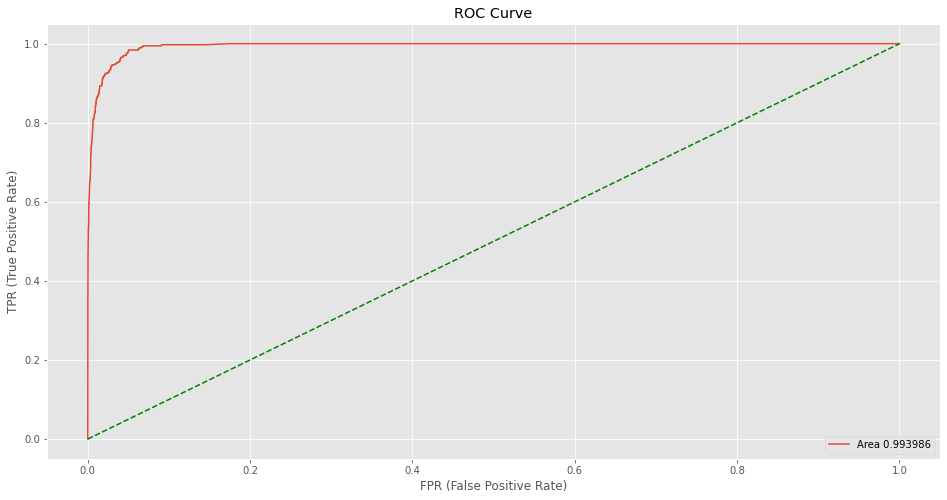

In [49]:

print('Calculations for Test Data\n\n')
confus_matrix = confusion_matrix(aps_test_data_y, predictions_of_test_data_y)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(aps_test_data_y, predictions_of_test_data_y)
print("\nThe Random Forest Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(aps_test_data_y,probablities_of_test_data_y[:,1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()

### *missclassification rate: 1-0.98825 = 0.01175*

In [50]:
out_of_bag_error,test_error= 1-random_forest.oob_score_,1-prediction_accuracy
print('Out of Bag Error :',out_of_bag_error)
print('Test Error: ',test_error)

Out of Bag Error : 0.009000000000000008
Test Error:  0.011750000000000038


In [51]:
test_error-out_of_bag_error

0.00275000000000003

We observe that the Out of Bag Error is close to the Test error. The difference between them is negligible (0.002 in our case).


## *Question 2.d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.*

In [52]:
# Note we are compensating for the class imbalance, balanced variable is set to True.

start = t.time()
random_forest,predictions_of_train_data_y,probablities_of_train_data_y=random_forest_classifier(True,aps_train_data_x,aps_train_data_y)
end = t.time()


# approximately 25 seconds.
print('Total Time taken for execution :',end-start)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Total Time taken for execution : 20.39461612701416


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Calculations for Training Data


Confusion Matrix 
[[56609  2391]
 [   32   968]]

The Random Forest Classification Accuracy 0.9596166666666667


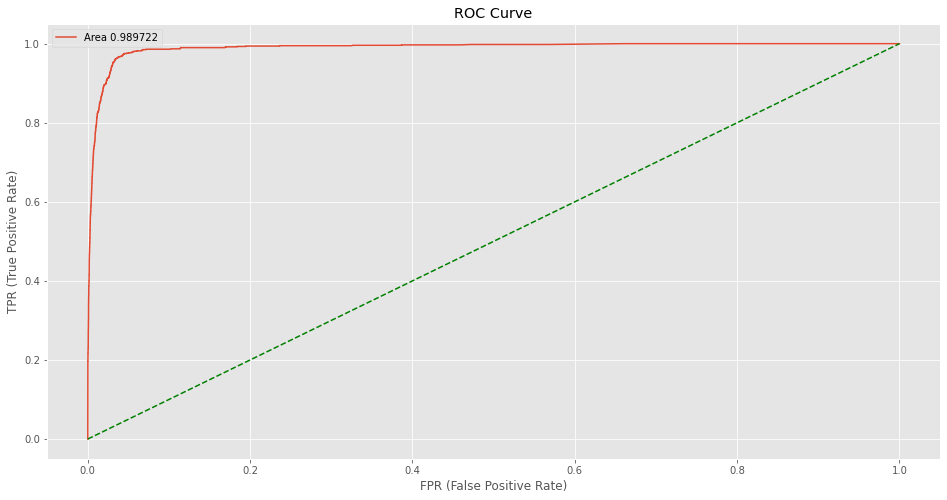

In [53]:

print('Calculations for Training Data\n\n')
confus_matrix = confusion_matrix(aps_train_data_y, predictions_of_train_data_y)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(aps_train_data_y, predictions_of_train_data_y)
print("\nThe Random Forest Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(aps_train_data_y,probablities_of_train_data_y[:,1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()

### *missclassification rate: 1-0.9596166666666667 = 0.0403833333*

In [54]:
predictions_of_test_data_y = random_forest.predict(aps_test_data_x)
probablities_of_test_data_y= random_forest.predict_proba(aps_test_data_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Calculations for Test Data


Confusion Matrix 
[[15005   620]
 [   16   359]]

The Random Forest Classification Accuracy 0.96025


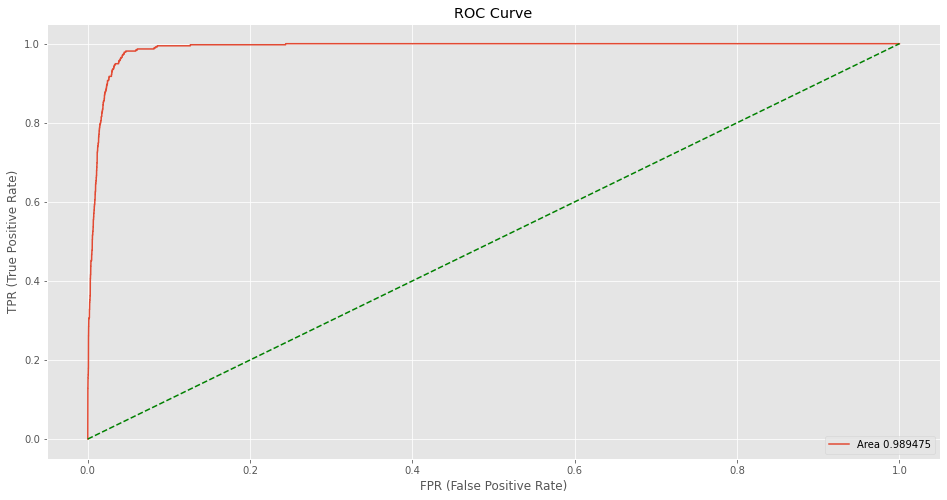

In [55]:

print('Calculations for Test Data\n\n')
confus_matrix = confusion_matrix(aps_test_data_y, predictions_of_test_data_y)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(aps_test_data_y, predictions_of_test_data_y)
print("\nThe Random Forest Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(aps_test_data_y,probablities_of_test_data_y[:,1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()

### *missclassification rate: 1-0.96025 = 0.03975*

In [56]:
out_of_bag_error,test_error= 1-random_forest.oob_score_,1-prediction_accuracy
print('Out of Bag Error :',out_of_bag_error)
print('Test Error: ',test_error)

Out of Bag Error : 0.041483333333333317
Test Error:  0.03974999999999995


In [57]:
abs(test_error-out_of_bag_error)

0.0017333333333333645

Even after addressing the class imbalance issue, we observe that the Out of Bag Error is close to the Test error. The difference between them is negligible (0.001 in our case).

At first look, the case without compensation wins the race because it has the highest test accuracy. But since our dataset is imbalanced (higher number of negative samples compared to the positive samples), the model might have just predicted negative samples correctly with high accuracy.
Taking a look at our confusion matrix we can understand that the compensated case performs better because it predicts the positive classes more accurately(199/375 v.s. 359/375).

## *Question 2.e) Model Trees using Weka.*

In [58]:
train_location = '../data/weka_train_data.csv'
test_location = '../data/weka_test_data.csv'

In [59]:
weka_aps_train_data = aps_train_data_x.copy()
weka_aps_test_data = aps_test_data_x.copy()
weka_aps_test_data.loc[:, 'class'] = aps_test_data_y
weka_aps_train_data.loc[:, 'class'] = aps_train_data_y


weka_aps_train_data.to_csv(train_location, index=False)
weka_aps_test_data.to_csv(test_location, index=False)

In [60]:

def load_weka():
    weka_loader = Loader(classname="weka.core.converters.CSVLoader")
    weka_train_data = weka_loader.load_file(train_location)
    weka_test_data = weka_loader.load_file(test_location)
    weka_test_data.class_is_last()
    weka_train_data.class_is_last()
    return weka_loader,weka_train_data,weka_test_data

weka_loader,weka_train_data,weka_test_data = load_weka()

###  *Weka Logistic Model Trees(LMT) for classification:10-fold validation on training data*

In [61]:
# Time taken : approximately 4 hrs
def lmt_cross_validation(weka_train_data):
    start = t.time()
    lmt_model = Classifier(classname='weka.classifiers.trees.LMT')
    evaluation = Evaluation(weka_train_data)
    evaluation.crossvalidate_model(classifier=lmt_model, data=weka_train_data, num_folds = 10, rnd=Random(1234))
    end = t.time()
    print('Total Time taken for execution :',end-start)
    return lmt_model,evaluation

lmt_model,evaluation=lmt_cross_validation(weka_train_data)

Total Time taken for execution : 13874.124337911606


In [62]:
confus_matrix = evaluation.confusion_matrix
print("Confusion Matrix ")
print(confus_matrix)

Confusion Matrix 
[[58846.   154.]
 [  335.   665.]]


ROC Curve 


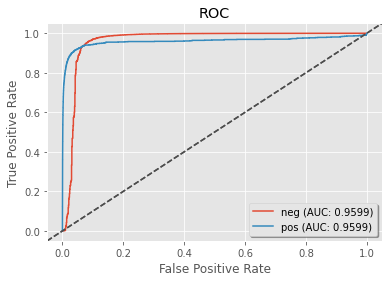

In [63]:
print("ROC Curve ")
plcls.plot_roc(evaluation, class_index=[0, 1], wait=True)

In [64]:
print(evaluation.summary())


Correctly Classified Instances       59511               99.185  %
Incorrectly Classified Instances       489                0.815  %
Kappa statistic                          0.7271
Mean absolute error                      0.0115
Root mean squared error                  0.0822
Relative absolute error                 35.1527 %
Root relative squared error             64.2242 %
Total Number of Instances            60000     



In [65]:
print(evaluation.class_details())

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.335    0.994      0.997    0.996      0.731    0.960     0.998     neg
                 0.665    0.003    0.812      0.665    0.731      0.731    0.960     0.751     pos
Weighted Avg.    0.992    0.329    0.991      0.992    0.991      0.731    0.960     0.994     



###  *Weka Logistic Model Trees(LMT) on test data*

In [66]:
lmt_model.build_classifier(weka_train_data)

test_predictions_weka = []
test_probablities_weka = []

for i in weka_test_data:
    test_predictions_weka.append(lmt_model.classify_instance(i))
    test_probablities_weka.append(lmt_model.distribution_for_instance(i))

test_predictions_weka = np.array(test_predictions_weka).astype('str')
test_predictions_weka[test_predictions_weka == '0.0'] = 'neg'
test_predictions_weka[test_predictions_weka == '1.0'] = 'pos'
test_probablities_weka = np.array(test_probablities_weka)

Calculations for Test Data


Confusion Matrix 
[[15625     0]
 [  375     0]]

The Random Forest Classification Accuracy 0.9765625


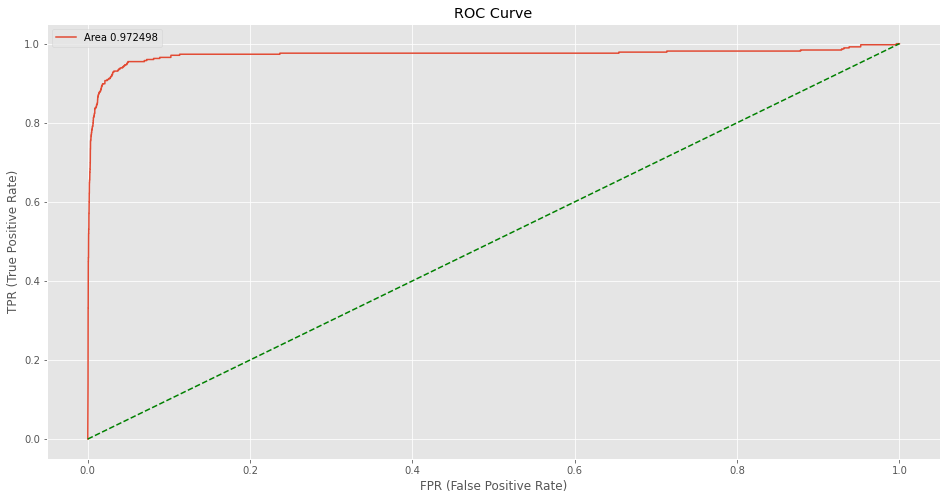

In [67]:
print('Calculations for Test Data\n\n')
confus_matrix = confusion_matrix(aps_test_data_y, test_predictions_weka)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(aps_test_data_y, test_predictions_weka)
print("\nThe Random Forest Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(aps_test_data_y,test_probablities_weka[:,1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()

### *Note: The accuracy is just Classification Accuracy, But since, We are repeating the steps from previous Questions, I missed deleting the word Random from printing..*
### *Since It took 12 hrs for me to run the weka code, I didn't re-run it, just to change the print statement.*

## *Question 2.f) SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance and repeat 2.e)*

In [70]:
# Performing 5 cross-validation.

def perform_smote(aps_train_data_x,aps_train_data_y,cross_validation_error):
    data_split = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    for t_i, c_i in data_split.split(aps_train_data_x, aps_train_data_y):
        ith_train_data_x = aps_train_data_x.iloc[t_i, :]
        ith_train_data_y = aps_train_data_y.iloc[t_i]
        bi_ith_train_data_y = ith_train_data_y.replace({'neg' : 0.0, 'pos' : 1.0})
        ith_cross_validation_data_x = aps_train_data_x.iloc[c_i, :]
        ith_cross_validation_data_y = aps_train_data_y.iloc[c_i]
        smote = SMOTE(random_state=1234)
        smote_train_data_x, smote_train_data_y = smote.fit_resample(ith_train_data_x,bi_ith_train_data_y)
        smote_train_data_x.loc[:, 'class'] = smote_train_data_y.replace({0.0 : 'neg', 1.0 : 'pos'})
        ith_cross_validation_data_x.loc[:, 'class'] = ith_cross_validation_data_y
        new_train_location = '../data/tmp_smote_train_data.csv'
        new_cv_location = '../data/tmp_smote_valid_data.csv'
        ith_cross_validation_data_x.to_csv(new_cv_location, index=False)
        smote_train_data_x.to_csv(new_train_location, index=False)
        weka_train_data = weka_loader.load_file(new_train_location)
        weka_cv_data = weka_loader.load_file(new_cv_location)
        weka_train_data.class_is_last()
        weka_cv_data.class_is_last()
        lmt_model = Classifier(classname='weka.classifiers.trees.LMT')
        lmt_model.build_classifier(weka_train_data)
        evaluation = Evaluation(weka_train_data)
        evaluation.test_model(lmt_model, weka_cv_data)
        cross_validation_error.append(evaluation.percent_correct)
    return lmt_model,evaluation,cross_validation_error,smote


start = t.time()
lmt_model,evaluation,cross_validation_error,smote = perform_smote(aps_train_data_x,aps_train_data_y,[])
end = t.time()
print('Total Time taken for execution :',end-start)

for i in cross_validation_error:
    print(100-i)

Total Time taken for execution : 15634.828011989594
1.9749999999999943
2.0416666666666714
2.316666666666663
1.9166666666666714
2.3916666666666657


### *Performing SMOTE on complete Dataset*

In [72]:

smote_weka_train_data_x, smote_weka_train_data_y = smote.fit_resample(aps_train_data_x,aps_train_data_y.replace({0.0 : 'neg', 1.0 : 'pos'}))

smote_train_location = '../data/smote_weka_train_data.csv'
smote_weka_train_data_x.loc[:, 'class'] = smote_weka_train_data_y.replace({0.0 : 'neg', 1.0 : 'pos'})
smote_weka_train_data_x.to_csv(smote_train_location, index=False)

weka_train_data = weka_loader.load_file(smote_train_location)
weka_train_data.class_is_last()

lmt_model.build_classifier(weka_train_data)


train_predictions_weka = []
train_probablities_weka = []


for i in weka_train_data:
    train_predictions_weka.append(lmt_model.classify_instance(i))
    train_probablities_weka.append(lmt_model.distribution_for_instance(i))

train_predictions_weka = np.array(train_predictions_weka).astype('str')
train_predictions_weka[train_predictions_weka == '0.0'] = 'neg'
train_predictions_weka[train_predictions_weka == '1.0'] = 'pos'
train_probablities_weka = np.array(train_probablities_weka)


Calculations for Training Data


Confusion Matrix 
[[58548   452]
 [  229 58771]]

The Classification Accuracy 0.994228813559322


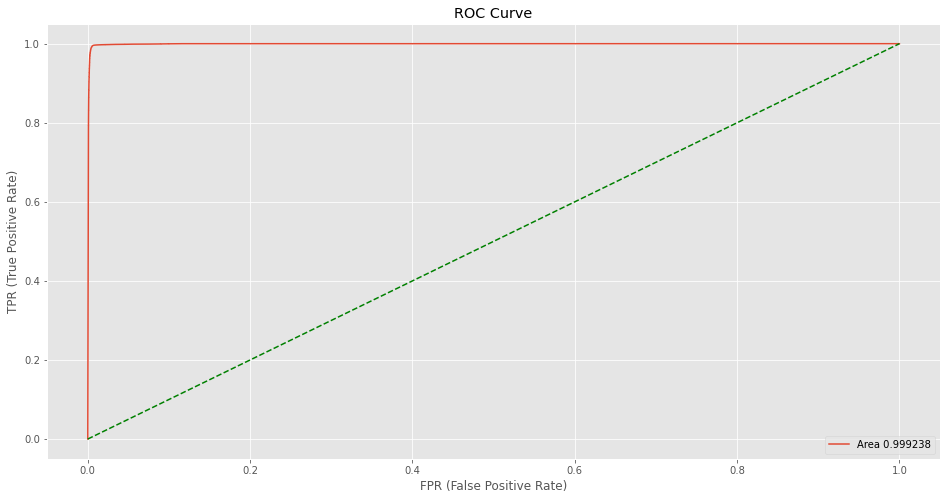

In [79]:
print('Calculations for Training Data\n\n')
confus_matrix = confusion_matrix(smote_weka_train_data_y.replace({0.0 : 'neg', 1.0 : 'pos'}), train_predictions_weka)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(smote_weka_train_data_y.replace({0.0 : 'neg', 1.0 : 'pos'}), train_predictions_weka)
print("\nThe Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(smote_weka_train_data_y.replace({0.0 : 'neg', 1.0 : 'pos'}),train_probablities_weka[:, 1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()

Calculations for Test Data


Confusion Matrix 
[[15625     0]
 [  375     0]]

The Classification Accuracy 0.9765625


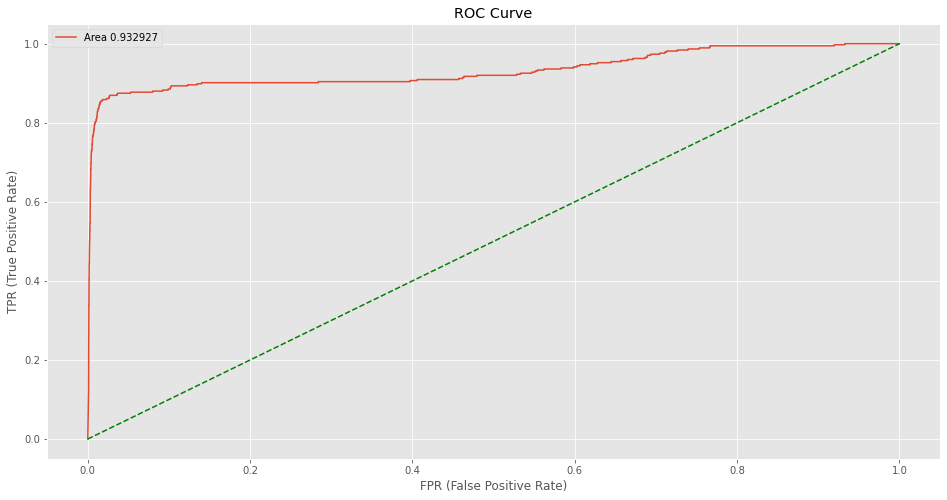

In [80]:
test_predictions_weka = []
test_probablities_weka = []

for i in weka_test_data:
    test_predictions_weka.append(lmt_model.classify_instance(i))
    test_probablities_weka.append(lmt_model.distribution_for_instance(i))

test_predictions_weka = np.array(test_predictions_weka).astype('str')
test_predictions_weka[test_predictions_weka == '0.0'] = 'neg'
test_predictions_weka[test_predictions_weka == '1.0'] = 'pos'
test_probablities_weka = np.array(test_probablities_weka)


print('Calculations for Test Data\n\n')
confus_matrix = confusion_matrix(aps_test_data_y, test_predictions_weka)
print("Confusion Matrix ")
print(confus_matrix)

prediction_accuracy = accuracy_score(aps_test_data_y, test_predictions_weka)
print("\nThe Classification Accuracy",prediction_accuracy)


false_positive_rate,true_positive_rate , _ = roc_curve(aps_test_data_y,test_probablities_weka[:, 1], pos_label='pos')
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axes = plt.subplots(figsize=(16, 8))

axes.plot(false_positive_rate, true_positive_rate, label='Area %f'%roc_auc)
axes.plot([0, 1], [0, 1], "--",color='green')
axes.legend()
axes.set_ylabel("TPR (True Positive Rate)")
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_title("ROC Curve")
plt.show()

We can see the improvement in the performance of the classification of minority class after applying smote. Better classification of the positive class is observed after SMOTE.

## *Question 3) ISLR 6.6.3*

a. iv) Steadily decreases. 

Reason: When the value of s is equal to zero we will have the effect of infinite regularization for lasso. As the value of s increases from 0, the β values will increase from 0 to their ordinary least squares (OLS) value. The value of training error is maximum when β values are 0, and the value of training error steadily decreases for the OLS residual sum of squares.

b. ii) Decrease initially, and then eventually start increasing in a U shape.

Reason: When s=0, all the β values are zero, the model will not fit both training data and test data well, hence the test RSS will be high. As the value of s starts to increase from 0, it will start fitting both the training and test data well, hence the test error will keep decreasing till a sweet spot. After a specific value of s, the β values will increase to high values and it will lead us to have more predictors and inturn the model will overfit the training data, thus the test RSS will start to increase.

c. iii) Steadily increase.

Reason: When s=0, all the β values are zero, and the model is simple with high bias and no variance. As the value of s keeps increasing the model starts choosing more number β's and their values also start to increase. Hence, the flexibility or complexity of the model keeps increasing as it fits the training data extremely well. Hence, the value of variance steadily increases as we increase s from 0.

d. iv) Steadily decrease.

Reason: When s=0, all the β values are zero, and the model is simple because it just predicts a constant, so it has a high bias. As the value of s keeps increasing the model starts choosing more number β's and their values also start to increase. Hence, the flexibility or complexity of the model keeps increasing as it fits the training data well. Hence, the value of bias steadily decreases as we increase s from 0.

e. v) Remains constant.

Reason: The irreducible error will remain constant irrespective of the value of s because it is model-independent.

## *Question 4) ISLR 6.6.5*

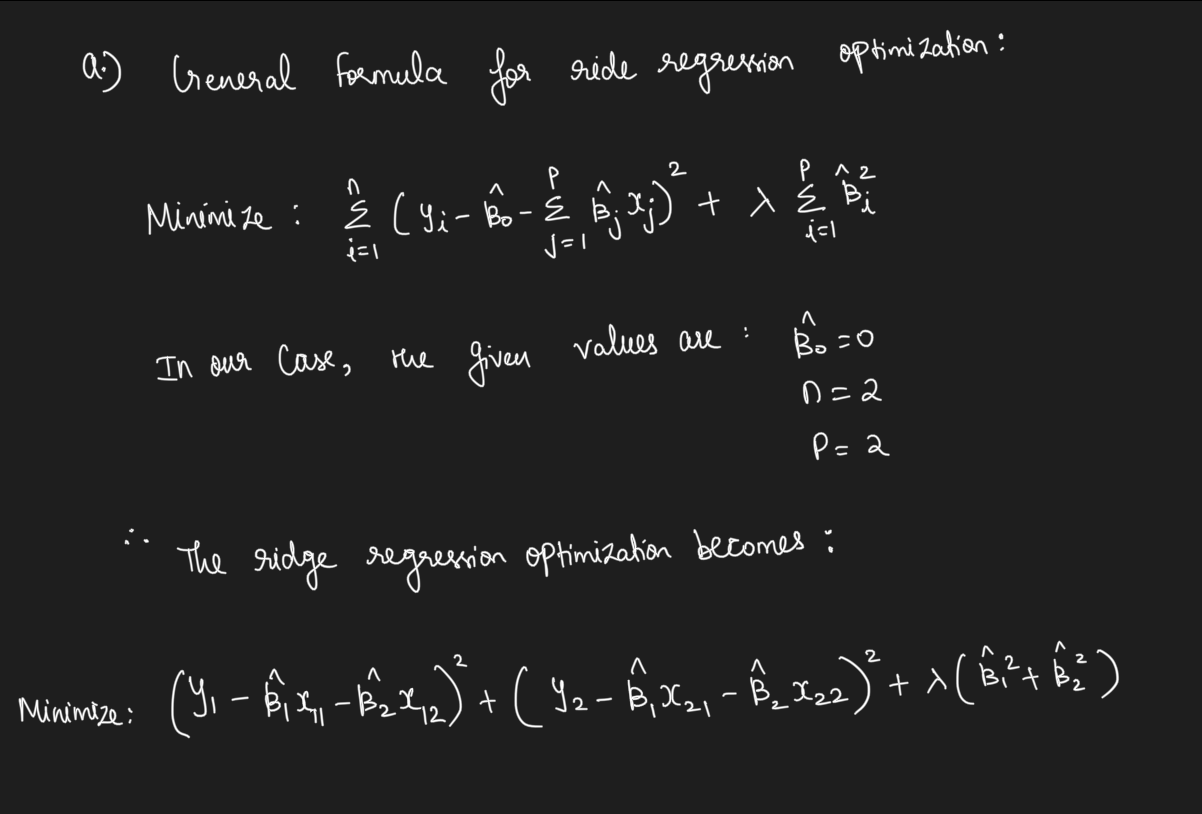

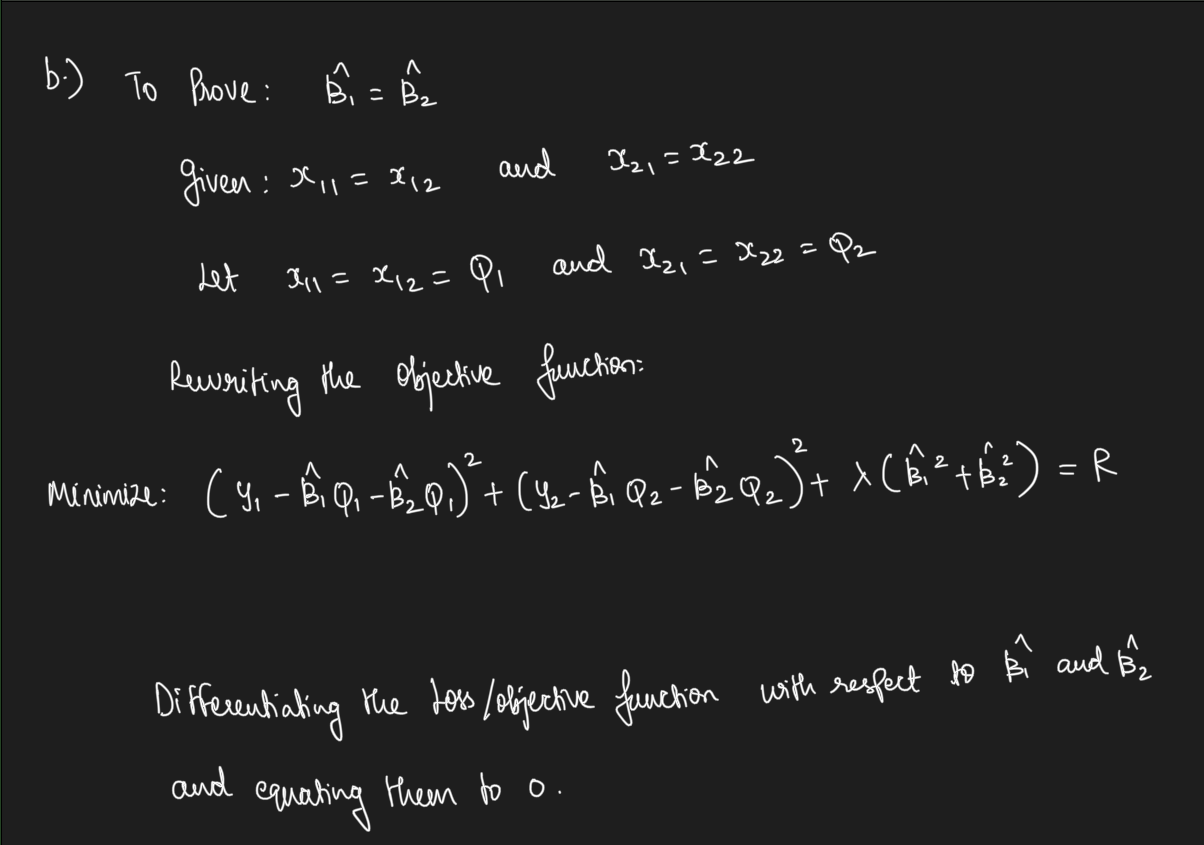

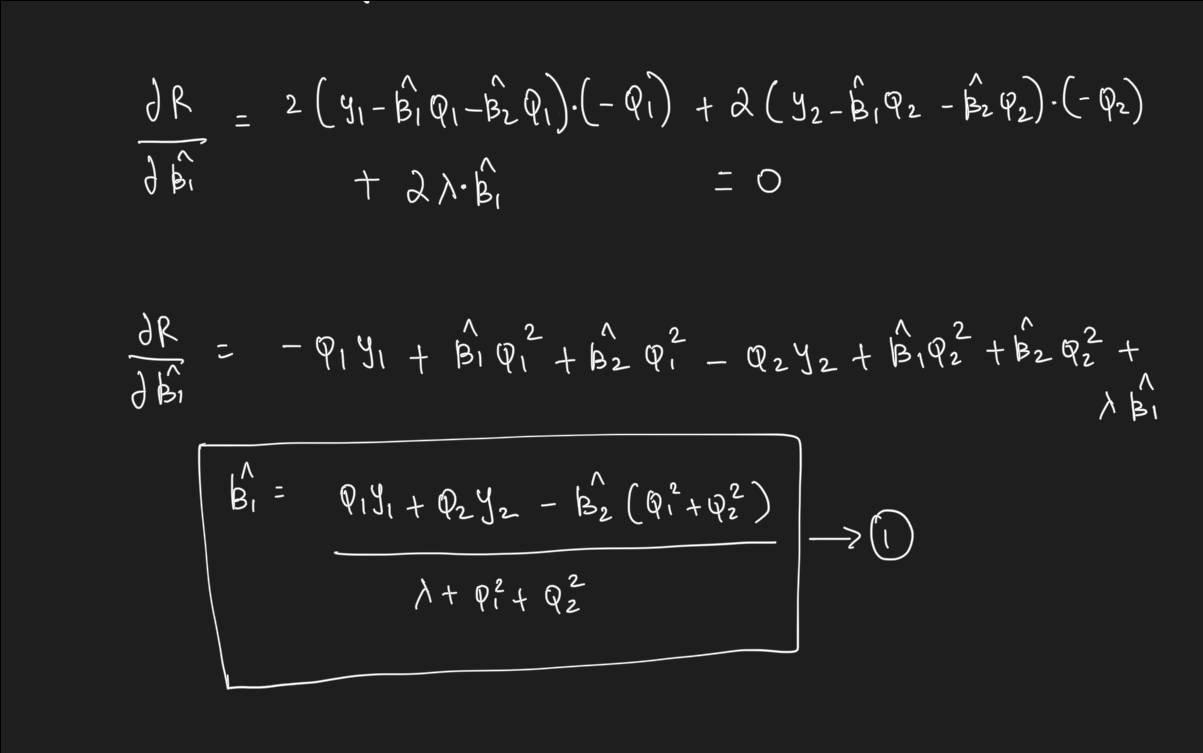

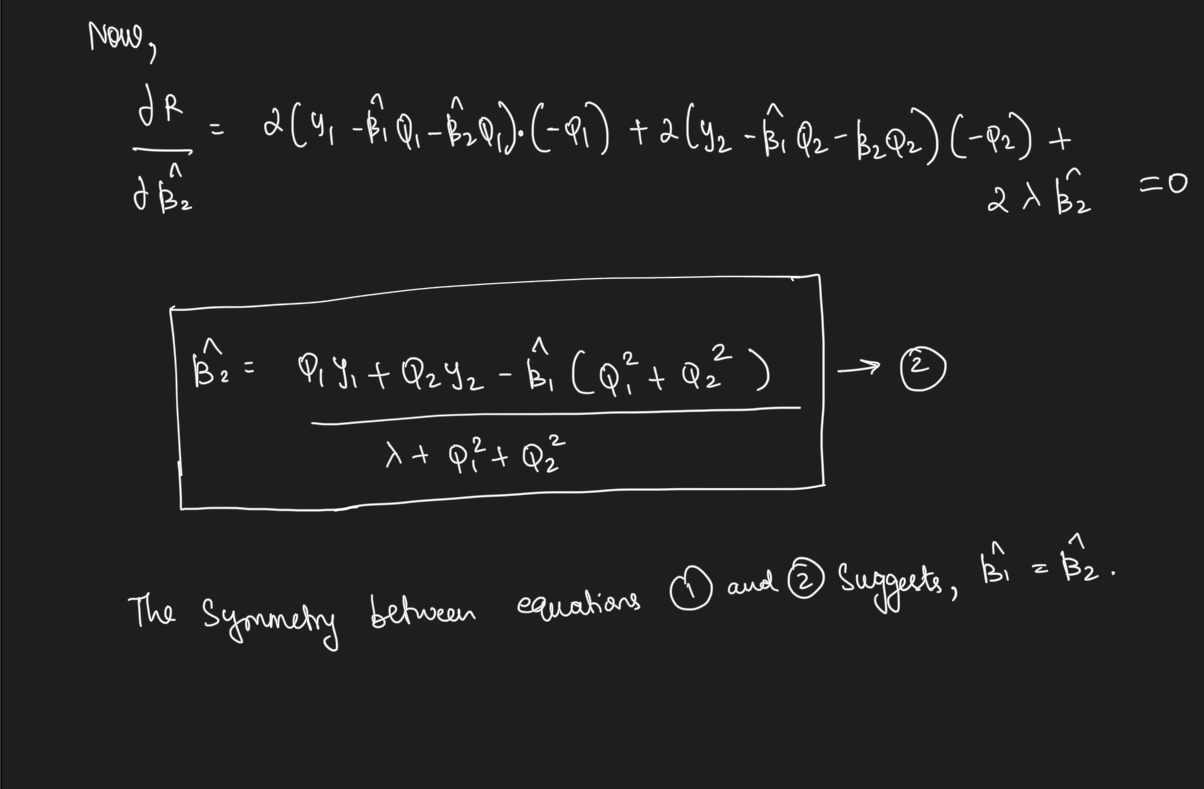

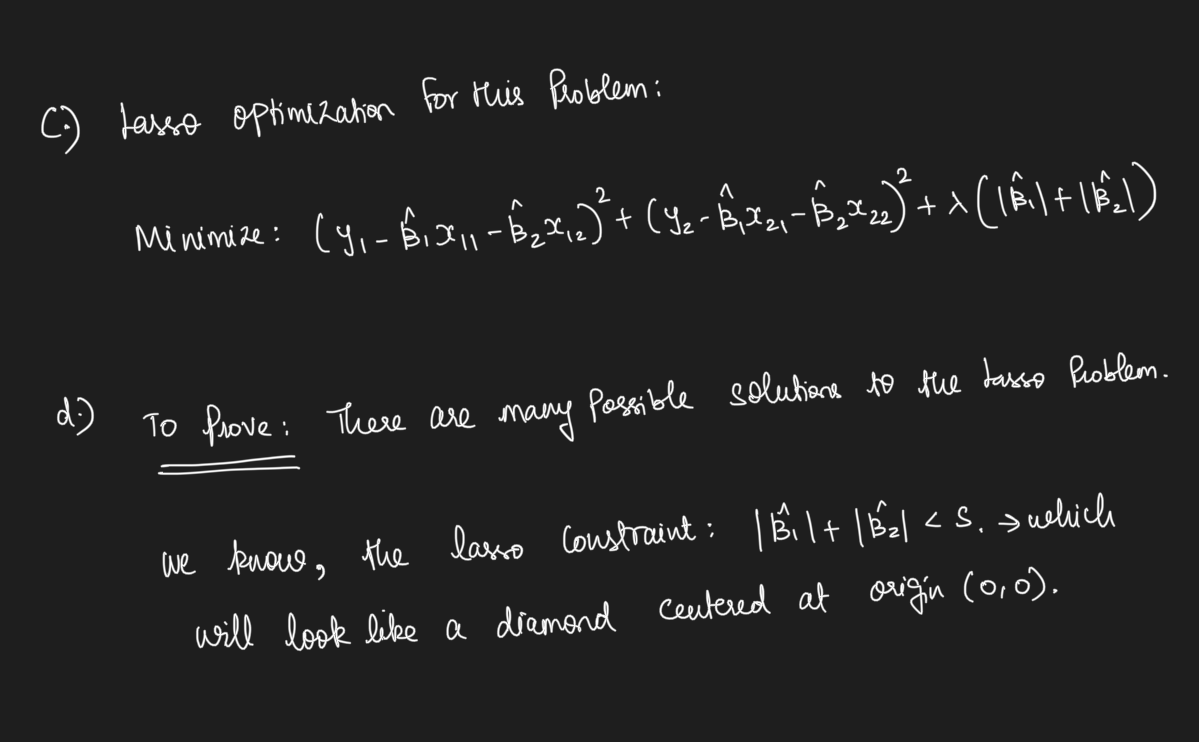

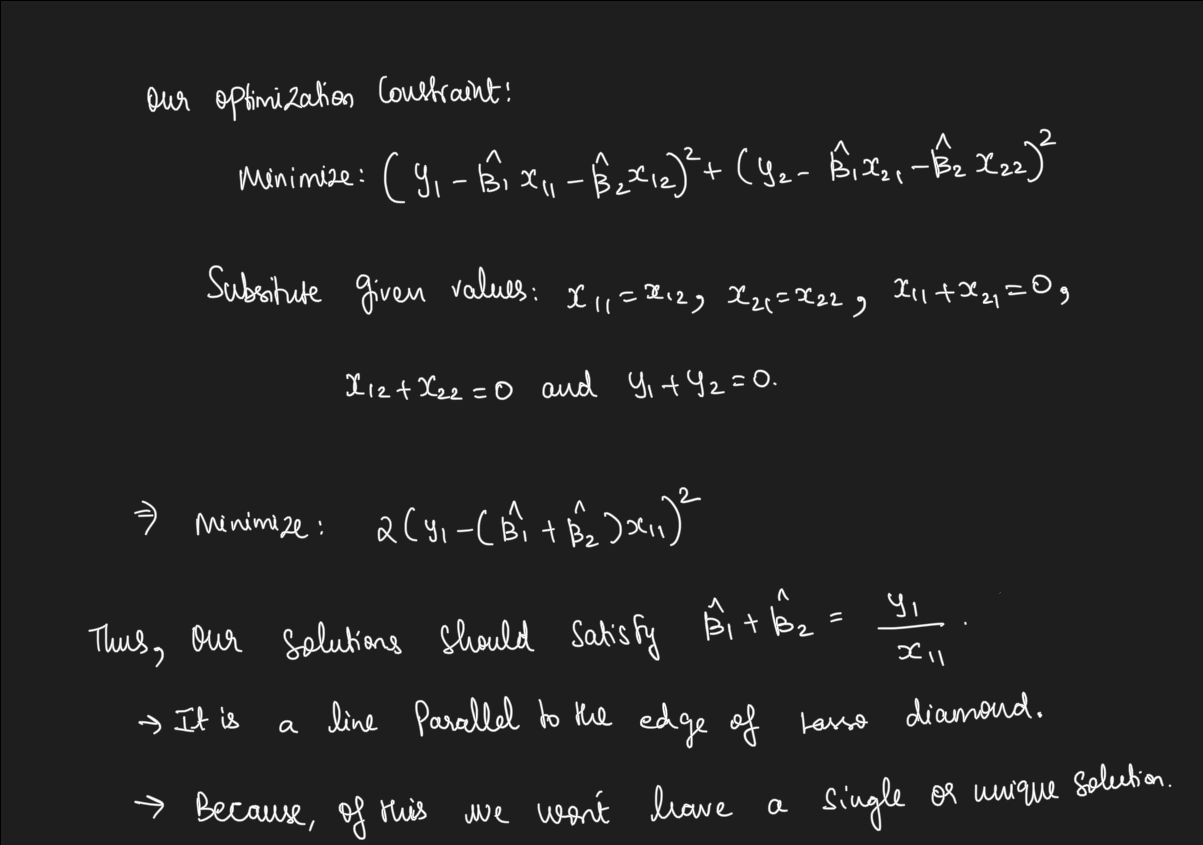

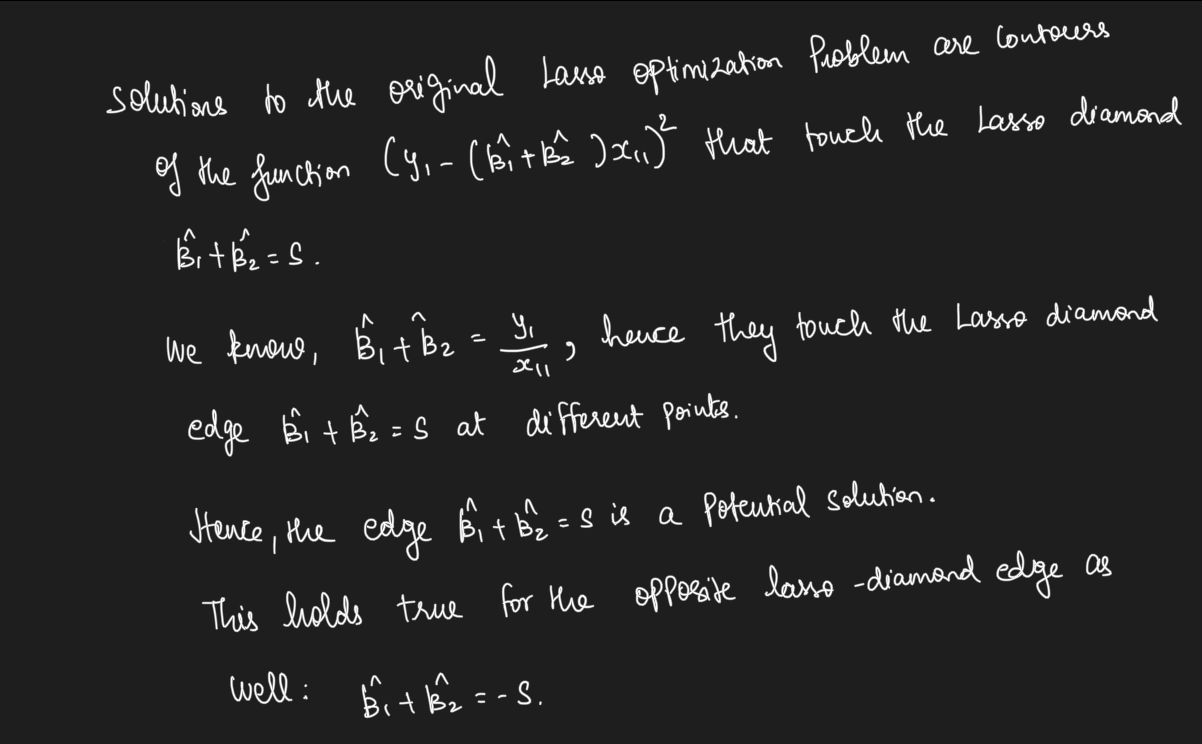

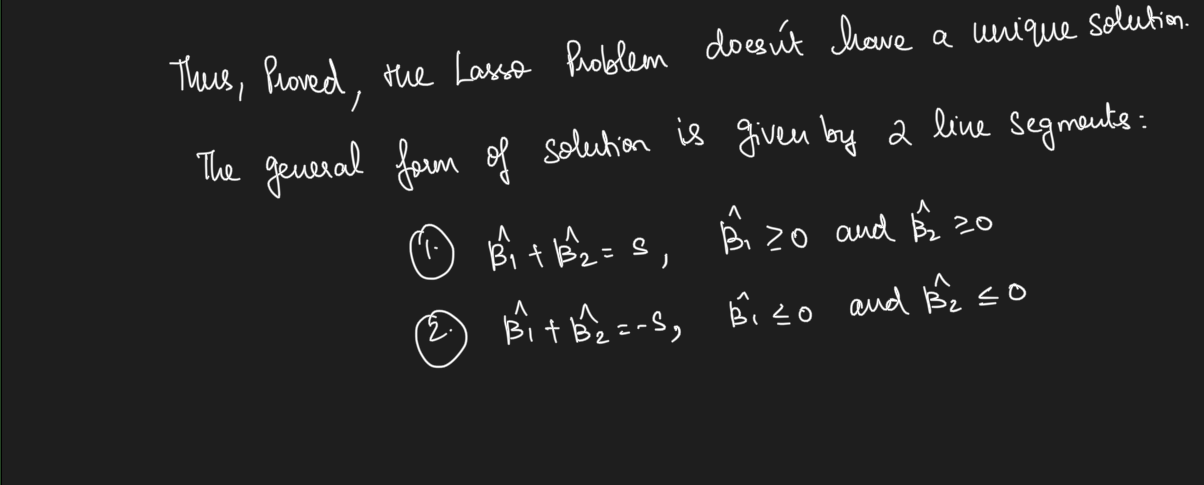

## *Question 5) ISLR 8.4.5*

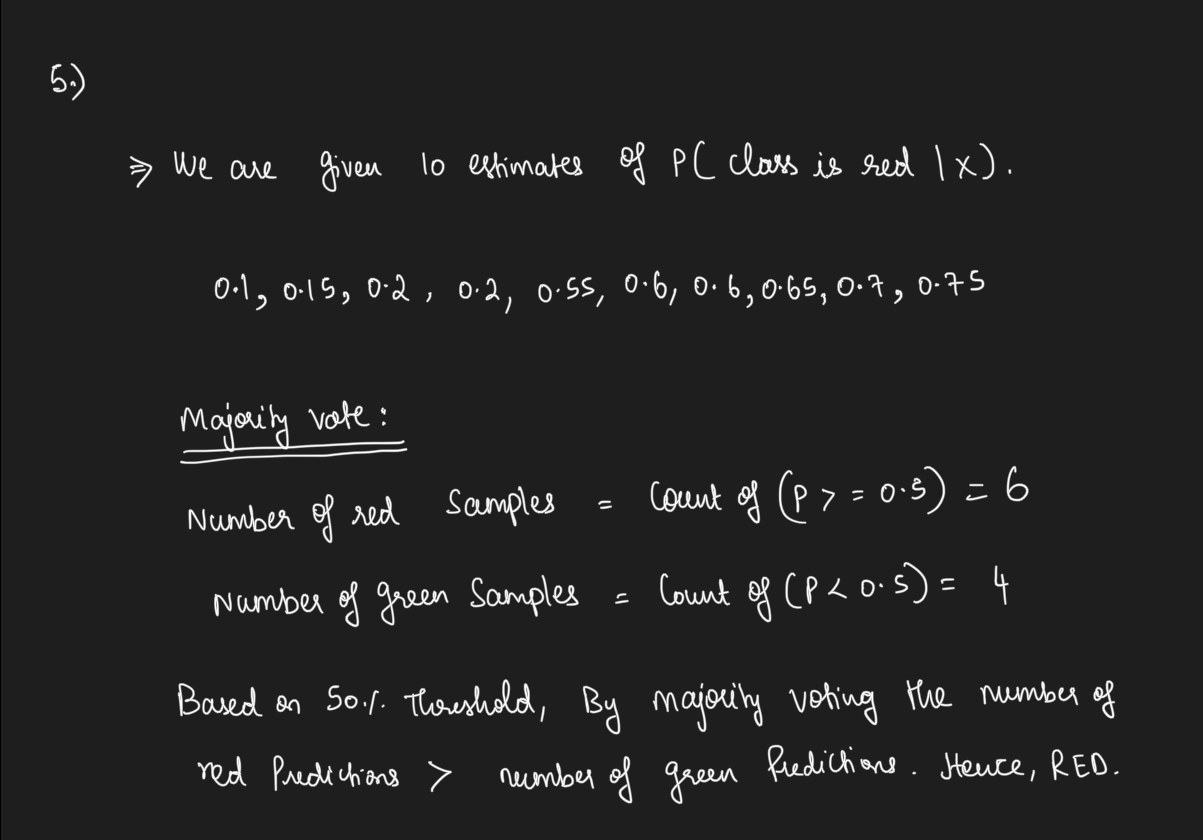

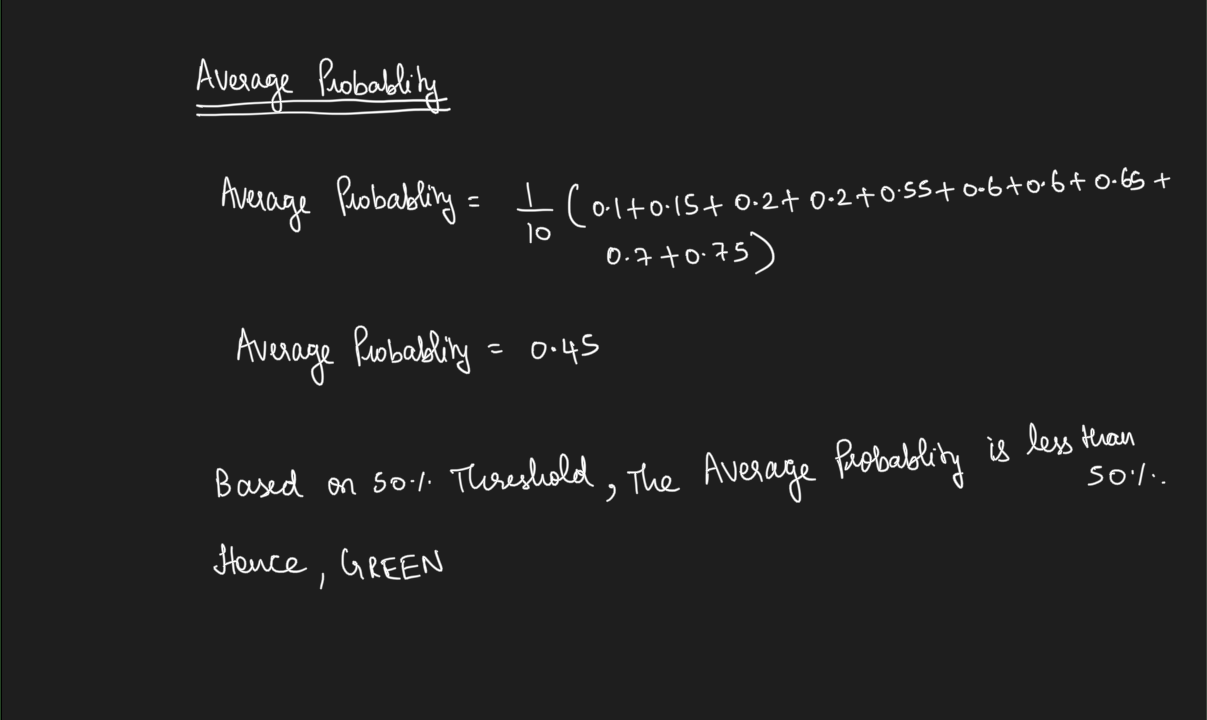

## *Question 6) ISLR 9.7.3*

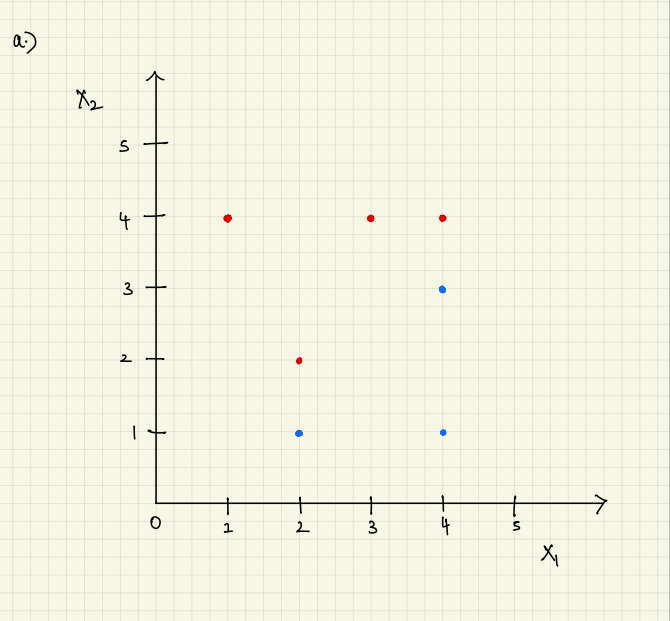

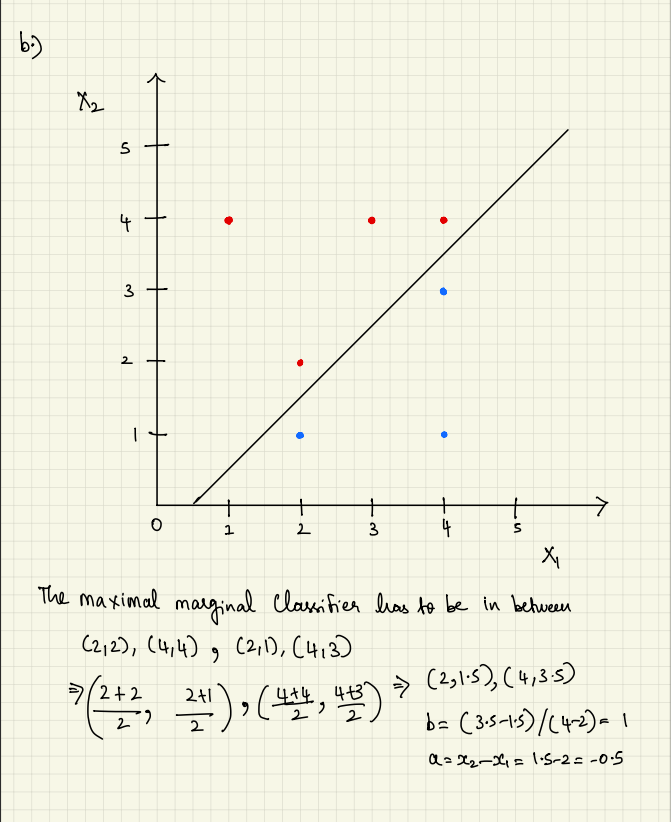

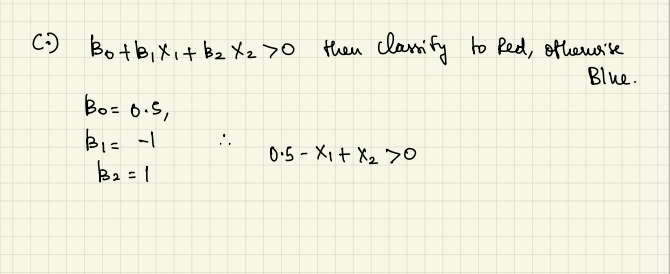

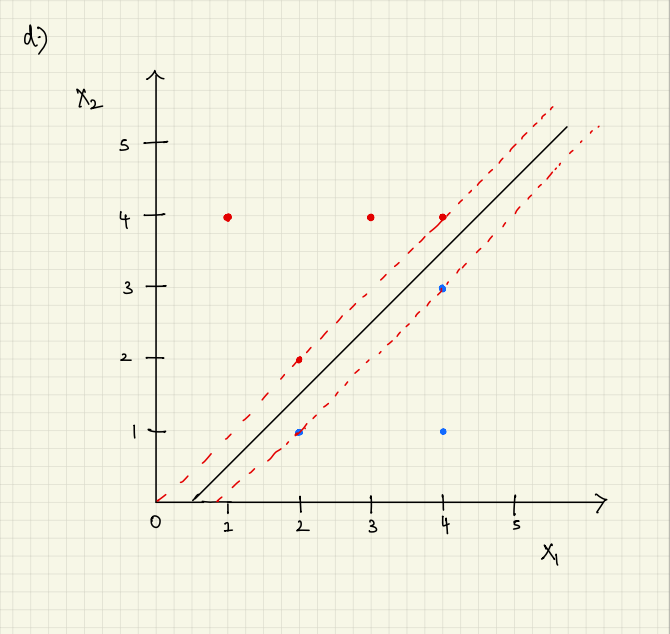

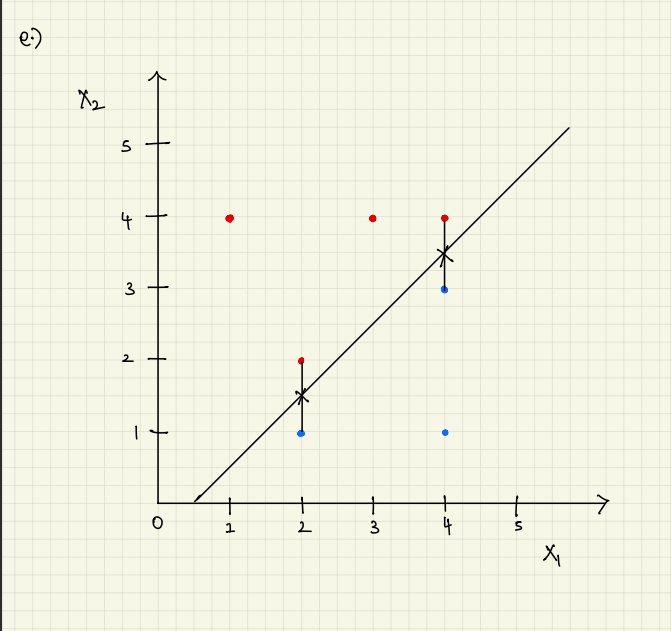

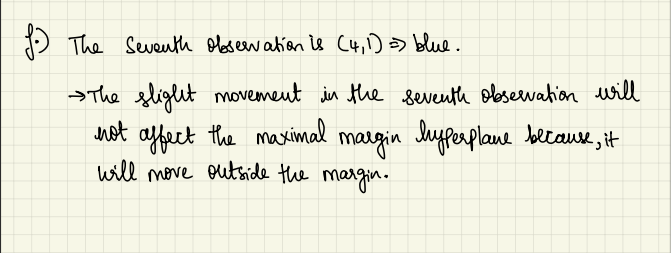

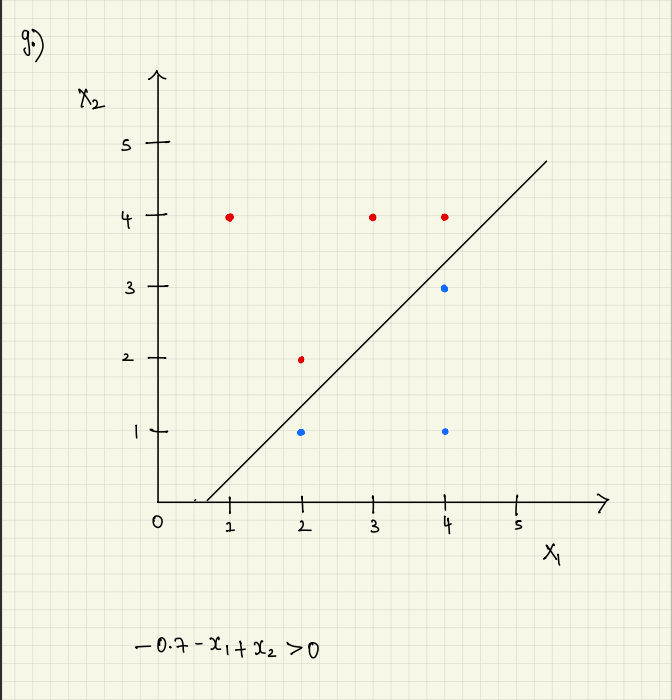

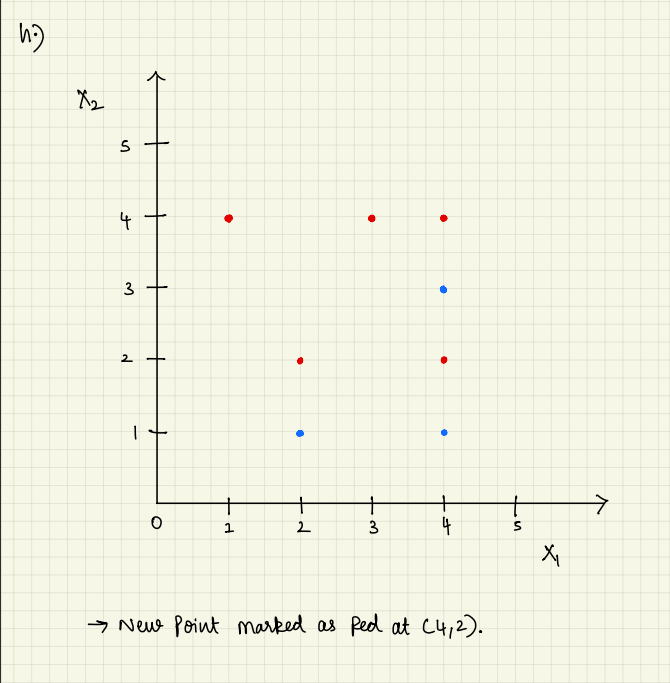